In [ ]:
import zipfile
import os

# Unzipping the dataset
dataset_zip_path = '/content/drive/MyDrive/computer vision/face_recognition_dataset.zip'
unzip_path = '/content/drive/MyDrive/computer vision/face_recognition_dataset'

with zipfile.ZipFile(dataset_zip_path, 'r') as zip_ref:
    zip_ref.extractall(unzip_path)

print("Dataset unzipped successfully!")


Dataset unzipped successfully!


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
import os
import cv2
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from collections import OrderedDict
# visualization
from PIL import Image
# identifying faces
%pip install mtcnn
from mtcnn.mtcnn import MTCNN
# visualizing bounding boxes
import matplotlib.patches as patches
# CNN
import keras
from sklearn.model_selection import train_test_split
# Moving files between directories
import shutil
from shutil import unpack_archive
from subprocess import check_output

dataset_path = "/content/drive/MyDrive/computer vision/face_recognition_dataset/lfw-deepfunneled/lfw-deepfunneled/"

In [ ]:
# Load datasets from the updated path
lfw_allnames = pd.read_csv("/content/drive/MyDrive/computer vision/face_recognition_dataset/lfw_allnames.csv")
matchpairsDevTest = pd.read_csv("/content/drive/MyDrive/computer vision/face_recognition_dataset/matchpairsDevTest.csv")
matchpairsDevTrain = pd.read_csv("/content/drive/MyDrive/computer vision/face_recognition_dataset/matchpairsDevTrain.csv")
mismatchpairsDevTest = pd.read_csv("/content/drive/MyDrive/computer vision/face_recognition_dataset/mismatchpairsDevTest.csv")
mismatchpairsDevTrain = pd.read_csv("/content/drive/MyDrive/computer vision/face_recognition_dataset/mismatchpairsDevTrain.csv")
pairs = pd.read_csv("/content/drive/MyDrive/computer vision/face_recognition_dataset/pairs.csv")

# Tidy pairs data
pairs = pairs.rename(columns={'name': 'name1', 'Unnamed: 3': 'name2'})
matched_pairs = pairs[pairs["name2"].isnull()].drop("name2", axis=1)
mismatched_pairs = pairs[pairs["name2"].notnull()]

# Load people data
people = pd.read_csv("/content/drive/MyDrive/computer vision/face_recognition_dataset/people.csv")

# Remove null values
people = people[people.name.notnull()]

# Load additional datasets
peopleDevTest = pd.read_csv("/content/drive/MyDrive/computer vision/face_recognition_dataset/peopleDevTest.csv")
peopleDevTrain = pd.read_csv("/content/drive/MyDrive/computer vision/face_recognition_dataset/peopleDevTrain.csv")



In [ ]:
# shape data frame so there is a row per image, matched to relevant jpg file
image_paths = lfw_allnames.loc[lfw_allnames.index.repeat(lfw_allnames['images'])]
image_paths['image_path'] = 1 + image_paths.groupby('name').cumcount()
image_paths['image_path'] = image_paths.image_path.apply(lambda x: '{0:0>4}'.format(x))
image_paths['image_path'] = image_paths.name + "/" + image_paths.name + "_" + image_paths.image_path + ".jpg"
image_paths = image_paths.drop("images",axis=1)

# take a random sample: 80% of the data for the test set
lfw_train, lfw_test = train_test_split(image_paths, test_size=0.2)
lfw_train = lfw_train.reset_index().drop("index",axis=1)
lfw_test = lfw_test.reset_index().drop("index",axis=1)

# verify that there is a mix of seen and unseen individuals in the test set
print(len(set(lfw_train.name).intersection(set(lfw_test.name))))
print(len(set(lfw_test.name) - set(lfw_train.name)))

838
854


<Axes: xlabel='name'>

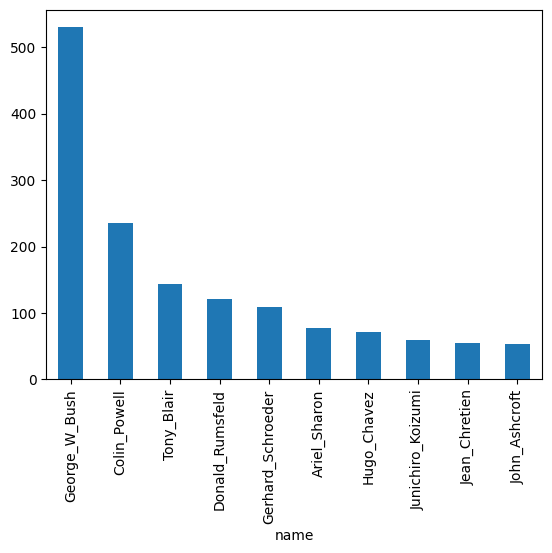

In [ ]:
image_paths['name'].value_counts()[:10].plot(kind = "bar")


In [ ]:
ind_counts = image_paths.groupby('name').count().image_path
print(str(sum(ind_counts[ind_counts==1])) + " individuals, which is " + str(round(100*(sum(ind_counts[ind_counts==1])/sum(ind_counts)))) + "% of the total individuals considered, are only represented by a single image in this dataset.")

4069 individuals, which is 31% of the total individuals considered, are only represented by a single image in this dataset.


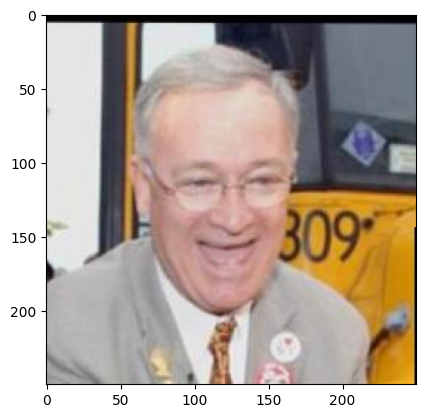

In [ ]:
im = Image.open("/content/drive/MyDrive/computer vision/face_recognition_dataset/lfw-deepfunneled/lfw-deepfunneled/" + str(lfw_train.image_path[0]))
plt.imshow(im)

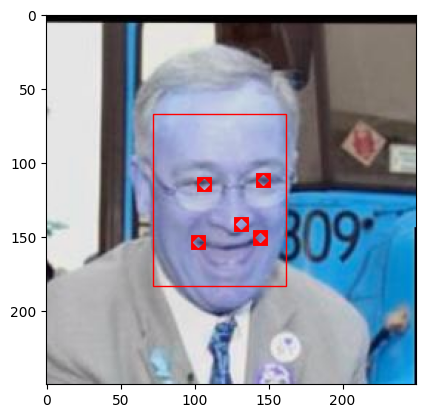

In [ ]:
# Use out-of-the-box MTCNN algorithm to identify facial boundaries on a sample image
detector = MTCNN()
image = cv2.imread("/content/drive/MyDrive/computer vision/face_recognition_dataset/lfw-deepfunneled/lfw-deepfunneled/" + str(lfw_train.image_path[0]))
result = detector.detect_faces(image)
# That's it - the results have already been generated! Now we extract the boundaries that have been identified
bounding_box = result[0]['box']
keypoints = result[0]['keypoints']

# Finally, we plot the image along with the face's bounding box and internal features (eyes, nose, and mouth corners)
fig,ax = plt.subplots(1)
ax.imshow(image)
# Create a Rectangle patch
rect = patches.Rectangle(bounding_box[0:2],bounding_box[2],bounding_box[3],linewidth=1,edgecolor='r',facecolor='none')
# Add the patch to the Axes
ax.add_patch(rect)
# Visualize all the internal features
for key in keypoints:
    rect_key = patches.Rectangle(keypoints[key],1,1,linewidth=10,edgecolor='r',facecolor='none')
    ax.add_patch(rect_key)
# Show the plots
plt.show()

In [ ]:
not_george = image_paths[image_paths.name!="George_W_Bush"].sample(530)
not_george.name = "not_George"
GWB_data = pd.concat([image_paths[image_paths.name=="George_W_Bush"],
                     not_george])

In [ ]:
# withhold final test data
bush_train, bush_test = train_test_split(GWB_data, test_size=0.2)
#  It is also useful to reserve a validation set in the training data, for use in the model construction
bush_train, bush_val = train_test_split(bush_train,test_size=0.2)

In [ ]:
# initialize sequential network
from keras.models import Sequential
# include convolutional layers
from keras.layers import Conv2D
# Pooling layers
from keras.layers import MaxPooling2D
# flatten layers into single vector
from keras.layers import Flatten
from keras.layers import Dense

In [ ]:
# use sequential classifier - standard CNN implementation with straightforward single input
Bush_classifier = Sequential()
# We then add layers of complexity to this classifier. The first layer we add is a 2D convolutional layer (as
# explained above); we pass over the image with a 3x3 window and expect 250*250 pixel input.
# The activation function to introduce non-linearity  is 'relu': Rectified Linear Units, a simple activation function
# with low computational speeds. One potential downside is that ReLU can lead to "dying neurons", where a neuron is
# attributed zero influence on classification and gets stuck in this state; we can see output where many neurons have
# zero influence on the model. If this behaviour manifested in further analysis, an alternate activation function e.g.
# 'leaky ReLU' would be worth exploring as an alternative
Bush_classifier.add(Conv2D(32, (3, 3), input_shape = (250, 250, 3), activation = 'relu'))

# We now add the pooling layer to reduce the dimension
Bush_classifier.add(MaxPooling2D(pool_size = (2, 2)))

# The next step is to flatten the data, reducing the feature maps to a 1D array
Bush_classifier.add(Flatten())

# We then add a fully connected layer - traditional Multi Layer Perceptron
Bush_classifier.add(Dense(units = 128, activation = 'relu'))

# as we are just training on 'Bush' vs 'non-Bush', we only need to add one classification unit
Bush_classifier.add(Dense(units = 1, activation = 'sigmoid'))

# We are now ready to compile the model. It is possible, and advisable, to introduce more layers to the network, but
# as this model is exploratory we are keeping things straightforward for now (this would change in future iterations)
Bush_classifier.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
# define a custom function to move images to a new train/test/val directory

def directory_mover(data,dir_name):
    co = 0
    for image in data.image_path:
        # create top directory
        if not os.path.exists(os.path.join('/content/drive/MyDrive/computer vision',dir_name)):
            shutil.os.mkdir(os.path.join('/content/drive/MyDrive/computer vision',dir_name))

        data_type = data[data['image_path'] == image]['name']
        data_type = str(list(data_type)[0])
        if not os.path.exists(os.path.join('/content/drive/MyDrive/computer vision',dir_name,data_type)):
            shutil.os.mkdir(os.path.join('/content/drive/MyDrive/computer vision',dir_name,data_type))
        path_from = os.path.join('/content/drive/MyDrive/computer vision/face_recognition_dataset/lfw-deepfunneled/lfw-deepfunneled/',image)
        path_to = os.path.join('/content/drive/MyDrive/computer vision',dir_name,data_type)
        # print(path_to)
        shutil.copy(path_from, path_to)
        # print('Moved {} to {}'.format(image,path_to))
        co += 1

    print('Moved {} images to {} folder.'.format(co,dir_name))

In [ ]:
# move images:
directory_mover(bush_train,"Bush_train/")
directory_mover(bush_val,"Bush_val/")
directory_mover(bush_test,"Bush_test/")

Moved 678 images to Bush_train/ folder.
Moved 170 images to Bush_val/ folder.
Moved 212 images to Bush_test/ folder.


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Creating training and validation data generators
train_datagen = ImageDataGenerator(rescale=1./255, shear_range=0.2, zoom_range=0.2, horizontal_flip=True)
test_datagen = ImageDataGenerator(rescale=1./255)

# Loading training, validation, and test sets
Bush_training_set = train_datagen.flow_from_directory(
    '/content/drive/MyDrive/computer vision/Bush_train/',
    target_size=(250, 250),
    batch_size=32,
    class_mode='binary'
)

Bush_val_set = test_datagen.flow_from_directory(
    '/content/drive/MyDrive/computer vision/Bush_val/',
    target_size=(250, 250),
    batch_size=32,
    class_mode='binary'
)

Bush_test_set = test_datagen.flow_from_directory(
    '/content/drive/MyDrive/computer vision/Bush_test/',
    target_size=(250, 250),
    batch_size=32,
    class_mode='binary'
)


Found 678 images belonging to 2 classes.
Found 170 images belonging to 2 classes.
Found 212 images belonging to 2 classes.


In [ ]:
Bush_history = Bush_classifier.fit(
    Bush_training_set,
    steps_per_epoch=678,
    epochs=8,
    validation_data=Bush_val_set,
    validation_steps=100
)


Epoch 1/8


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


 22/678 ━━━━━━━━━━━━━━━━━━━━ 4:25 404ms/step - accuracy: 0.5147 - loss: 16.2598

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


678/678 ━━━━━━━━━━━━━━━━━━━━ 25s 21ms/step - accuracy: 0.5205 - loss: 9.3976 - val_accuracy: 0.6353 - val_loss: 0.9264
Epoch 2/8
678/678 ━━━━━━━━━━━━━━━━━━━━ 13s 13ms/step - accuracy: 0.6084 - loss: 0.9939 - val_accuracy: 0.5765 - val_loss: 0.8746
Epoch 3/8
678/678 ━━━━━━━━━━━━━━━━━━━━ 20s 11ms/step - accuracy: 0.6759 - loss: 0.6333 - val_accuracy: 0.6471 - val_loss: 0.6407
Epoch 4/8
678/678 ━━━━━━━━━━━━━━━━━━━━ 14s 12ms/step - accuracy: 0.7419 - loss: 0.5382 - val_accuracy: 0.6471 - val_loss: 0.7995
Epoch 5/8
678/678 ━━━━━━━━━━━━━━━━━━━━ 20s 14ms/step - accuracy: 0.7328 - loss: 0.5186 - val_accuracy: 0.7294 - val_loss: 0.5601
Epoch 6/8
678/678 ━━━━━━━━━━━━━━━━━━━━ 21s 13ms/step - accuracy: 0.7887 - loss: 0.4676 - val_accuracy: 0.7235 - val_loss: 0.5646
Epoch 7/8
678/678 ━━━━━━━━━━━━━━━━━━━━ 19s 13ms/step - accuracy: 0.8106 - loss: 0.4082 - val_accuracy: 0.7471 - val_loss: 0.4988
Epoch 8/8
678/678 ━━━━━━━━━━━━━━━━━━━━ 21s 13ms/step - accuracy: 0.8414 - loss: 0.3646 - val_accuracy: 0.74

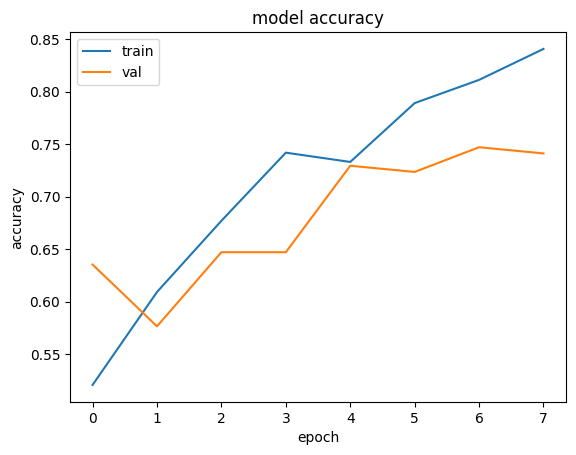

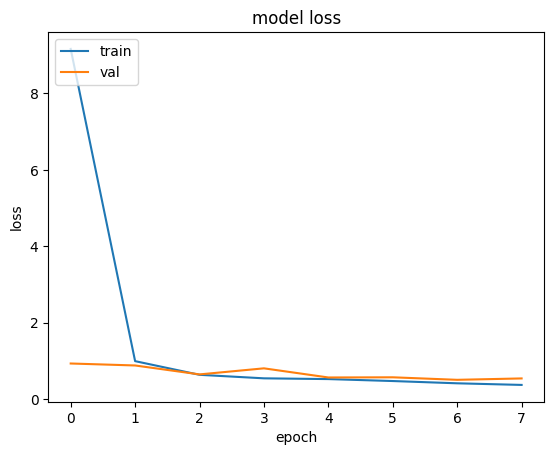

In [ ]:
plt.plot(Bush_history.history['accuracy'])
plt.plot(Bush_history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(Bush_history.history['loss'])
plt.plot(Bush_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
# Save the model to a specified path
Bush_classifier.save('/content/drive/MyDrive/computer vision/Bush_classifier_model.h5')
